In [1]:
from visualizer import get_local
get_local.activate()

import os
ROOT_PATH="/data/aofei"
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
os.environ["TRANSFORMERS_CACHE"] = f"{ROOT_PATH}/huggingface_cache/transformers"
os.environ["HF_HOME"] = f"{ROOT_PATH}/huggingface_cache/transformers"

from PIL import Image
import seaborn as sns
import torch
import torch.nn.functional as F
import json
import copy
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("/home/avc6555/research/MedH/Mitigation/LVLMs/llava-med")

from llava import LlavaLlamaForCausalLM
from llava.conversation import conv_templates
from llava.utils import disable_torch_init
from transformers import CLIPVisionModel, CLIPImageProcessor, StoppingCriteria
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

from PIL import Image
import random
import math

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytr

In [2]:
# load model
ROOT_PATH="/data/aofei"
model_name = f"{ROOT_PATH}/LLM/llava_med"

DEFAULT_IMAGE_TOKEN = "<image>"
DEFAULT_IMAGE_PATCH_TOKEN = "<im_patch>"
DEFAULT_IM_START_TOKEN = "<im_start>"
DEFAULT_IM_END_TOKEN = "<im_end>"

model_name = os.path.expanduser(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = LlavaLlamaForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, use_cache=True).cuda()
# print("vision tower", model.config.mm_vision_tower)
image_processor = CLIPImageProcessor.from_pretrained(model.config.mm_vision_tower, torch_dtype=torch.float16)
vision_tower = model.model.vision_tower[0]
vision_tower.to(device='cuda', dtype=torch.float16)

mm_use_im_start_end = getattr(model.config, "mm_use_im_start_end", False)
tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
if mm_use_im_start_end:
    tokenizer.add_tokens([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN], special_tokens=True)

vision_config = vision_tower.config
vision_config.im_patch_token = tokenizer.convert_tokens_to_ids([DEFAULT_IMAGE_PATCH_TOKEN])[0]
vision_config.use_im_start_end = mm_use_im_start_end
if mm_use_im_start_end:
    vision_config.im_start_token, vision_config.im_end_token = tokenizer.convert_tokens_to_ids([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN])
image_token_len = (vision_config.image_size // vision_config.patch_size) ** 2
print(image_token_len, "token length")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


/data/aofei/conda/env/medh/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

256 token length


In [3]:
import clip
_, preprocess = clip.load("ViT-B/32", device='cpu', jit=False)

class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords, tokenizer, input_ids):
        self.keywords = keywords
        self.tokenizer = tokenizer
        self.start_len = None
        self.input_ids = input_ids
        

    def __call__(self, output_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        if self.start_len is None:
            self.start_len = self.input_ids.shape[1]
        else:
            outputs = self.tokenizer.batch_decode(output_ids[:, self.start_len:], skip_special_tokens=True)[0]
            for keyword in self.keywords:
                if keyword in outputs:
                    return True
        return False
        

In [4]:
def get_attention_weights_example(model, question, image_path, conv_mode="simple"):
    qs = question.replace(DEFAULT_IMAGE_TOKEN, '').strip()
    
    image = Image.open(image_path)
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]
    images = image_tensor.unsqueeze(0).half().cuda()
    if getattr(model.config, 'mm_use_im_start_end', False):
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_PATCH_TOKEN * image_token_len + DEFAULT_IM_END_TOKEN + '\n' +  qs
    else:
        qs = DEFAULT_IMAGE_PATCH_TOKEN * image_token_len + '\n' + qs
    cur_prompt = '<image>' + '\n' +  qs

    conv = conv_templates[conv_mode].copy()
    conv.messages = []
    conv.append_message(conv.roles[0], qs)
    prompt = conv.get_prompt()
    inputs = tokenizer([prompt])

    input_ids = torch.as_tensor(inputs.input_ids).cuda()


    keywords = ['###']
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    

    with torch.inference_mode():
        outputs = model.generate(
            input_ids,
            images=images,
            do_sample=False,
            temperature=0.7,
            max_new_tokens=1024,
            output_attentions=True,
            return_dict_in_generate=True,
            stopping_criteria=[stopping_criteria])

    text = tokenizer.decode(outputs["sequences"][0]).strip()
    cache = get_local.cache
    print(text.split("###")[-2])
    return cache, text, outputs, input_ids, image

### The original model without probing training

In [33]:
question = "Does the picture contain liver?"
image_path = "./../images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)
print(text)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
len_out_tokens = len(outputs['attentions'])
for i in range(-len_out_tokens + 2, -len_out_tokens + 6):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token, "token")
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    image_attns = attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256]
    image_attn_sum = torch.sum(image_attns)
    # attn_before_image = attn_all_layers_tensor[:, :, :img_token_idx]
    # attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+256:]
    attn_before_image = attn_all_layers_tensor[:, :, 2:img_token_idx]
    attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+256:-2]
    text_attn_sum = torch.sum(attn_before_image)
    text_attn_sum2 = torch.sum(attn_after_image)
    print(image_attns.size(), image_attn_sum, attn_before_image.size(), attn_after_image.size(),  text_attn_sum, text_attn_sum2)

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 Assistant: Yes, the computed tomography (CT) scan of the abdomen shows the presence of liver tissue.

</s> A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <im_start><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_pa

In [34]:
len(outputs['attentions'])

30

In [35]:
all_visual_attention_ratios = []
total_visual_attention = None
head_attn_dict = dict()
for i in range(len(outputs['attentions'])):  # Assuming first dimension gives the range of i
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][-len_out_tokens + i])

    for layer in range(len(attn_all_layers)):
        for head in range(attn_all_layers[layer].size(1)):
            head_name = f"layer_{layer}_head_{head}"
            visual_attention_tensor = attn_all_layers[layer][0, head, img_token_idx+image_token_len:, img_token_idx:img_token_idx+image_token_len]
            if visual_attention_tensor.shape[0] == 0:
                continue
            if head_name not in head_attn_dict:
                head_attn_dict[head_name] = visual_attention_tensor
            else:
                # head_attn_dict[head_name] = head_attn_dict[head_name] + visual_attention_tensor
                head_attn_dict[head_name] = torch.cat([head_attn_dict[head_name], visual_attention_tensor], 0)

for key in head_attn_dict:
    head_attn_dict[key] = head_attn_dict[key].mean(0)

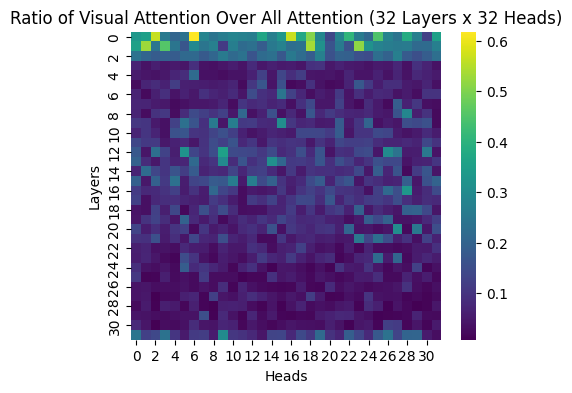

In [12]:
# Assume that the output attentions (outputs['attentions']) are of the shape (generated_token_length, layers, 1, heads, 1, current_seq_len)
# at the dimension of generated_token_length and layers, the format is a tuple, each item is a tensor in size (1, heads, 1, current_seq_len)
# I can get the attentions on visual tokens: image_attns = attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256], like what we used before
import matplotlib.pyplot as plt

all_visual_attention_ratios = []
for i in range(len(outputs['attentions'])):  # Assuming first dimension gives the range of i
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][-len_out_tokens + i])
    # print(token, "--> generated token")
    
    # Temporary list for this i
    visual_attention_ratios = []
    
    # Loop through layers and heads to calculate visual attention ratios
    for layer in range(len(attn_all_layers)):
        for head in range(attn_all_layers[layer].size(1)):
            visual_attention = torch.sum(attn_all_layers[layer][0, head, :, img_token_idx:img_token_idx+image_token_len])
            total_attention = torch.sum(attn_all_layers[layer][0, head, :, :])
            ratio = (visual_attention / total_attention).item()
            visual_attention_ratios.append(ratio)
    
    # Add the ratios for this i to the overall list
    all_visual_attention_ratios.append(visual_attention_ratios)

averaged_visual_attention_ratios = [
    sum(head_ratios) / len(all_visual_attention_ratios)
    for head_ratios in zip(*all_visual_attention_ratios)
]
# Reshape the ratios into a 32x32 matrix (32 layers, 32 heads)
averaged_visual_attention_ratios = np.array(averaged_visual_attention_ratios).reshape(32, 32)

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(averaged_visual_attention_ratios, annot=False, cmap='viridis', cbar=True)
# sns.heatmap(visual_attention_ratios, annot=True, cmap='viridis', cbar=True)
plt.title('Ratio of Visual Attention Over All Attention (32 Layers x 32 Heads)')
plt.xlabel('Heads')
plt.ylabel('Layers')
plt.show()


### The results after probing tuning (all lora)

In [13]:
#LOAD LORA
dir="llava_med/probing/lora"
model_probing = copy.deepcopy(model)
# dir="llava_med/visual_enhance/lora_0.03_bbox_0.01/epoch6"
# dir="llava_med/visual_enhance/abd/lora_0.15_bbox_0.02/epoch6"
dataset="Slake"
# dir="llava_med/lora/epoch6_bbox"
# dataset="VQA_RAD"
peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

if peft_path is not None and len(str(peft_path))>4:
    from peft import PeftModel
    print(f"Loading LoRA weights from {peft_path}")
    model_probing = PeftModel.from_pretrained(model_probing, peft_path)
    print(f"Merging weights")
    model_probing = model_probing.merge_and_unload()
    print('Convert to FP16...')
    model_probing.to(torch.float16)

Loading LoRA weights from /data/aofei/hallucination/mitigation/Slake/llava_med/probing/lora/checkpoints
Merging weights
Convert to FP16...


In [14]:
question = "Does the picture contain liver?"
image_path = "./../images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_probing, question=question, image_path=image_path)
print(text)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
len_out_tokens = len(outputs['attentions'])
for i in range(-len_out_tokens + 2, -len_out_tokens + 6):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token, "token")
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    image_attns = attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256]
    image_attn_sum = torch.sum(image_attns)
    # attn_before_image = attn_all_layers_tensor[:, :, :img_token_idx]
    # attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+256:]
    attn_before_image = attn_all_layers_tensor[:, :, 2:img_token_idx]
    attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+256:-2]
    text_attn_sum = torch.sum(attn_before_image)
    text_attn_sum2 = torch.sum(attn_after_image)
    print(image_attns.size(), image_attn_sum, attn_before_image.size(), attn_after_image.size(),  text_attn_sum, text_attn_sum2)

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 Assistant: The liver is located at bounding box coordinate [0.14, 0.29, 0.7, 0.72], and it is present in the image.

</s> A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <im_start><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><

ver --> generated token


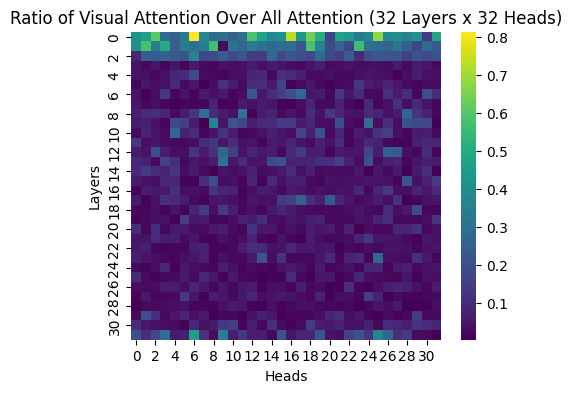

In [17]:
# Assume that the output attentions (outputs['attentions']) are of the shape (generated_token_length, layers, 1, heads, 1, current_seq_len)
# at the dimension of generated_token_length and layers, the format is a tuple, each item is a tensor in size (1, heads, 1, current_seq_len)
# I can get the attentions on visual tokens: image_attns = attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256], like what we used before
import matplotlib.pyplot as plt

i = 5
attn_all_layers = outputs['attentions'][i]
token = tokenizer.decode(outputs["sequences"][0][-len_out_tokens + i])
print(token, "--> generated token")
attn_all_layers[0].size()
# Calculate the ratio of visual attention over all attention for each head
visual_attention_ratios = []
for layer in range(len(attn_all_layers)):
    for head in range(attn_all_layers[layer].size(1)):
        visual_attention = torch.sum(attn_all_layers[layer][0, head, :, img_token_idx:img_token_idx+image_token_len])
        total_attention = torch.sum(attn_all_layers[layer][0, head, :, :])
        ratio = (visual_attention / total_attention).item()
        visual_attention_ratios.append(ratio)

# Reshape the ratios into a 32x32 matrix (32 layers, 32 heads)
visual_attention_ratios = np.array(visual_attention_ratios).reshape(32, 32)

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(visual_attention_ratios, annot=False, cmap='viridis', cbar=True)
# sns.heatmap(visual_attention_ratios, annot=True, cmap='viridis', cbar=True)
plt.title('Ratio of Visual Attention Over All Attention (32 Layers x 32 Heads)')
plt.xlabel('Heads')
plt.ylabel('Layers')
plt.show()


### The results after probing tuning (qk)

In [5]:
#LOAD LORA
dir="llava_med/probing/qk"
model_probing2 = copy.deepcopy(model)
# dir="llava_med/visual_enhance/lora_0.03_bbox_0.01/epoch6"
# dir="llava_med/visual_enhance/abd/lora_0.15_bbox_0.02/epoch6"
dataset="Slake"
# dir="llava_med/lora/epoch6_bbox"
# dataset="VQA_RAD"
peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

if peft_path is not None and len(str(peft_path))>4:
    from peft import PeftModel
    print(f"Loading LoRA weights from {peft_path}")
    model_probing2 = PeftModel.from_pretrained(model_probing2, peft_path)
    print(f"Merging weights")
    model_probing2 = model_probing2.merge_and_unload()
    print('Convert to FP16...')
    model_probing2.to(torch.float16)

Loading LoRA weights from /data/aofei/hallucination/mitigation/Slake/llava_med/probing/qk/checkpoints
Merging weights
Convert to FP16...


In [29]:
question = "Does the picture contain liver?"
image_path = "./../images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_probing2, question=question, image_path=image_path)
print(text)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
len_out_tokens = len(outputs['attentions'])
for i in range(-len_out_tokens + 2, -len_out_tokens + 6):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token, "token")
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    image_attns = attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256]
    image_attn_sum = torch.sum(image_attns)
    # attn_before_image = attn_all_layers_tensor[:, :, :img_token_idx]
    # attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+256:]
    attn_before_image = attn_all_layers_tensor[:, :, 2:img_token_idx]
    attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+256:-2]
    text_attn_sum = torch.sum(attn_before_image)
    text_attn_sum2 = torch.sum(attn_after_image)
    print(image_attns.size(), image_attn_sum, attn_before_image.size(), attn_after_image.size(),  text_attn_sum, text_attn_sum2)

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 Assistant: The liver is located at bounding box coordinate [0.13, 0.28, 0.37, 0.52], and it is present in the image.

</s> A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <im_start><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch>

In [30]:
all_visual_attention_ratios = []
total_visual_attention = None
head_attn_dict = dict()
for i in range(len(outputs['attentions'])):  # Assuming first dimension gives the range of i
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][-len_out_tokens + i])

    for layer in range(len(attn_all_layers)):
        for head in range(attn_all_layers[layer].size(1)):
            head_name = f"layer_{layer}_head_{head}"
            visual_attention_tensor = attn_all_layers[layer][0, head, img_token_idx+image_token_len:, img_token_idx:img_token_idx+image_token_len]
            if visual_attention_tensor.shape[0] == 0:
                continue
            if head_name not in head_attn_dict:
                head_attn_dict[head_name] = visual_attention_tensor
            else:
                # head_attn_dict[head_name] = head_attn_dict[head_name] + visual_attention_tensor
                head_attn_dict[head_name] = torch.cat([head_attn_dict[head_name], visual_attention_tensor], 0)

for key in head_attn_dict:
    head_attn_dict[key] = head_attn_dict[key].mean(0)


In [ ]:
# the average attention pattern for each head
head_attn_dict['layer_0_head_0'].size()

torch.Size([256])

In [32]:
kv_head_attn_dict = copy.deepcopy(head_attn_dict)

In [37]:
# compare the attention pattern change after the finetuning
def compute_kl_divergence(p, q):
    # Normalize to convert to probability distributions
    p = p / p.sum()
    q = q / q.sum()
    # Compute KL divergence (add a small epsilon for numerical stability)
    kl_div = F.kl_div(p.log(), q, reduction='batchmean')
    return kl_div.item()

# Compare KL divergence for each key
kl_divergences = {}
for key in head_attn_dict.keys():
    kl_divergences[key] = compute_kl_divergence(head_attn_dict[key], kv_head_attn_dict[key])


In [38]:
top_k = 32  # Replace with the desired number of top items
sorted_kl = sorted(kl_divergences.items(), key=lambda x: abs(x[1]), reverse=True)

# Get top-K items
top_k_items = sorted_kl[:top_k]

print("\nTop-K items with most distribution changes:")
for key, kl in top_k_items:
    print(f"{key}: {kl}")


Top-K items with most distribution changes:
layer_31_head_1: 0.00042057037353515625
layer_22_head_17: 0.0003101825714111328
layer_19_head_15: 0.0002923011779785156
layer_31_head_17: 0.0002689361572265625
layer_18_head_18: 0.0002613067626953125
layer_20_head_27: 0.0002551078796386719
layer_30_head_21: 0.0002503395080566406
layer_13_head_14: 0.00023698806762695312
layer_12_head_5: 0.0002090930938720703
layer_27_head_3: 0.00019431114196777344
layer_21_head_23: 0.00017952919006347656
layer_31_head_27: 0.00017952919006347656
layer_31_head_11: 0.00017261505126953125
layer_23_head_20: 0.00016677379608154297
layer_23_head_27: 0.00014090538024902344
layer_22_head_5: 0.00014078617095947266
layer_27_head_2: 0.0001341104507446289
layer_31_head_3: 0.00013303756713867188
layer_28_head_25: 0.00013267993927001953
layer_21_head_17: 0.00012803077697753906
layer_28_head_0: 0.00012791156768798828
layer_28_head_1: 0.0001277923583984375
layer_12_head_11: 0.00012755393981933594
layer_12_head_2: 0.0001246929

In [1]:
layers = """layer_31_head_1: 0.00042057037353515625
layer_22_head_17: 0.0003101825714111328
layer_19_head_15: 0.0002923011779785156
layer_31_head_17: 0.0002689361572265625
layer_18_head_18: 0.0002613067626953125
layer_20_head_27: 0.0002551078796386719
layer_30_head_21: 0.0002503395080566406
layer_13_head_14: 0.00023698806762695312
layer_12_head_5: 0.0002090930938720703
layer_27_head_3: 0.00019431114196777344
layer_21_head_23: 0.00017952919006347656
layer_31_head_27: 0.00017952919006347656
layer_31_head_11: 0.00017261505126953125
layer_23_head_20: 0.00016677379608154297
layer_23_head_27: 0.00014090538024902344
layer_22_head_5: 0.00014078617095947266
layer_27_head_2: 0.0001341104507446289
layer_31_head_3: 0.00013303756713867188
layer_28_head_25: 0.00013267993927001953
layer_21_head_17: 0.00012803077697753906
layer_28_head_0: 0.00012791156768798828
layer_28_head_1: 0.0001277923583984375
layer_12_head_11: 0.00012755393981933594
layer_12_head_2: 0.0001246929168701172
layer_29_head_14: 0.0001207590103149414
layer_26_head_14: 0.00012052059173583984
layer_31_head_24: 0.00012028217315673828
layer_17_head_5: 0.00011932849884033203
layer_12_head_0: 0.0001169443130493164
layer_21_head_9: 0.00011497735977172852
layer_19_head_17: 0.00010830163955688477
layer_28_head_17: 0.00010699033737182617"""

In [7]:
len(layers.split("\n")), layers.split("\n")[0], layers.split("\n")[0].split("_")

(32,
 'layer_31_head_1: 0.00042057037353515625',
 ['layer', '31', 'head', '1: 0.00042057037353515625'])

In [8]:
top_heads_indices = []
for i in layers.split("\n"):
    layer = i.split("_")[1]
    head = i.split("_")[3].split(":")[0]
    top_heads_indices.append((int(layer), int(head)))

In [10]:
set([i[0] for i in top_heads_indices])

{12, 13, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31}

In [11]:
top_heads_indices

[(31, 1),
 (22, 17),
 (19, 15),
 (31, 17),
 (18, 18),
 (20, 27),
 (30, 21),
 (13, 14),
 (12, 5),
 (27, 3),
 (21, 23),
 (31, 27),
 (31, 11),
 (23, 20),
 (23, 27),
 (22, 5),
 (27, 2),
 (31, 3),
 (28, 25),
 (21, 17),
 (28, 0),
 (28, 1),
 (12, 11),
 (12, 2),
 (29, 14),
 (26, 14),
 (31, 24),
 (17, 5),
 (12, 0),
 (21, 9),
 (19, 17),
 (28, 17)]

li --> generated token


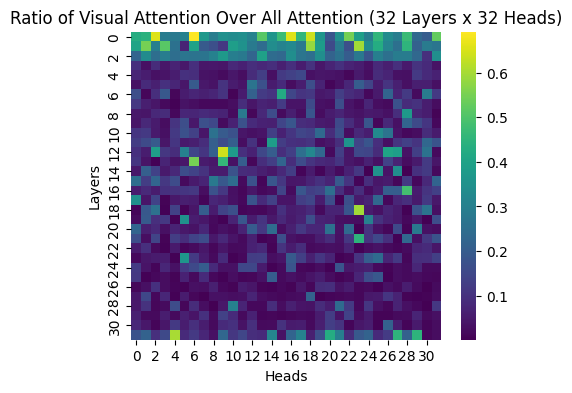

In [9]:
# Assume that the output attentions (outputs['attentions']) are of the shape (generated_token_length, layers, 1, heads, 1, current_seq_len)
# at the dimension of generated_token_length and layers, the format is a tuple, each item is a tensor in size (1, heads, 1, current_seq_len)
# I can get the attentions on visual tokens: image_attns = attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256], like what we used before
import matplotlib.pyplot as plt

i = 4
attn_all_layers = outputs['attentions'][i]
token = tokenizer.decode(outputs["sequences"][0][-len_out_tokens + i])
print(token, "--> generated token")
attn_all_layers[0].size()
# Calculate the ratio of visual attention over all attention for each head
visual_attention_ratios = []
for layer in range(len(attn_all_layers)):
    for head in range(attn_all_layers[layer].size(1)):
        visual_attention = torch.sum(attn_all_layers[layer][0, head, :, img_token_idx:img_token_idx+image_token_len])
        total_attention = torch.sum(attn_all_layers[layer][0, head, :, :])
        ratio = (visual_attention / total_attention).item()
        visual_attention_ratios.append(ratio)

# Reshape the ratios into a 32x32 matrix (32 layers, 32 heads)
visual_attention_ratios = np.array(visual_attention_ratios).reshape(32, 32)

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(visual_attention_ratios, annot=False, cmap='viridis', cbar=True)
# sns.heatmap(visual_attention_ratios, annot=True, cmap='viridis', cbar=True)
plt.title('Ratio of Visual Attention Over All Attention (32 Layers x 32 Heads)')
plt.xlabel('Heads')
plt.ylabel('Layers')
plt.show()
